# Define class StockCracker

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='ticks')
%matplotlib inline
#---- for jupyter notebook inline plot
import bokeh.plotting as bp
from bokeh import palettes, charts
bp.output_notebook()
#---- for color, style print in iPython
from IPython.display import HTML, display
import datetime
import os
#---- for colorful print
from colorama import init
init(autoreset=True)
from colorama import Fore, Back, Style

class StockCracker:
    def __init__(self):
        self.rootPath = './'
        self.USDJPYPath = './fx/USDJPY/'
        self.mazdaPath = './Mazda/'
        self.nikkeiPath = './Nikkei/'

    # read one csv file
    def readOneCsv(self, filePath, isReversed):
        data = pd.read_csv(filePath, encoding='shift-JIS', header=0)
        if isReversed is True:
            data = data.reindex(index=data.index[::-1])
            data.index = range(len(data))
        print(Fore.YELLOW + data['日付'][0] + '~' + data['日付'][len(data)-1])
        return data

    # read one folder, recurssively
    def readOneFolder(self, folderPath, isReversed=True):
        for root, subdirs, files in os.walk(folderPath):
            print('----------------')
            print(Back.CYAN + Fore.RED + Style.BRIGHT + 
                  'In Folder:'+root)
            for oneCsv in files:
                print(Back.CYAN + oneCsv)
                filePath = folderPath+oneCsv
                data = self.readOneCsv(filePath, isReversed)
                try:
                    allData
                except NameError:   # allData not exist
                    allData = data
                else:   # allData exist
                    # concatenate 2 pandas dataframes
                    allData = pd.concat([allData, data])
        allData.index = range(len(allData))
        #print(allData) # output all data of target stock
        return allData

    # calculate Beta coefficient, 
    def calcBetaCoefficient(self, stock, index):
#### following example gives a good intuition about the quantitative  
#        >>> a = np.array([1,3,9,6,5])
#        >>> b = a + 100
#        >>> b
#        array([101, 103, 109, 106, 105])
#        >>> np.cov(a,b,bias=1)
#        array([[ 7.36,  7.36],
#                [ 7.36,  7.36]])
#        >>> b = a * 10
#        >>> np.cov(a,b,bias=1)
#        array([[   7.36,   73.6 ],
#               [  73.6 ,  736.  ]])
        dailyChange_stock = [(stock['始値'][idx+1] - stock['始値'][idx]) / stock['始値'][idx] for idx in range(len(stock) - 1)] # from 0 ~ len(stock)-1
        dailyChange_index = [(index['始値'][idx+1] - index['始値'][idx]) / index['始値'][idx] for idx in range(len(index) - 1)] # from 0 ~ len(index)-1

        matrix = np.cov(dailyChange_stock, dailyChange_index, bias=1)        
        print(matrix)
        beta = matrix[0][1] / matrix[1][1]

        return beta
    
sc = StockCracker()

Loading BokehJS ...

In [5]:
sc = StockCracker()
# reading data ------------------------------------
data_Nikkei = sc.readOneFolder(sc.nikkeiPath)
data_Mazda  = sc.readOneFolder(sc.mazdaPath)
data_fx     = sc.readOneFolder(sc.USDJPYPath, False)
## convert date
date_Mazda    = [datetime.datetime.strptime(d, '%Y-%m-%d').date() for d in data_Mazda['日付'][:]]
date_Nikkei   = [datetime.datetime.strptime(d, '%Y-%m-%d').date() for d in data_Nikkei['日付'][:]]
date_fx       = [datetime.datetime.strptime(d, '%Y/%m/%d').date() for d in data_fx['日付'][:]]
### for Mazda, 2014-07-29 株併合:1株 -> 0.2株
index = data_Mazda.loc[data_Mazda['日付'] == '2014-07-28'].index[0]
data_Mazda['始値'][0:(index+1)] = data_Mazda['始値'][0:(index+1)] * 5



----------------
In Folder:./Nikkei/
indices_I101_1d_2007.csv
2007-01-04~2007-12-28
indices_I101_1d_2008.csv
2008-01-04~2008-12-30
indices_I101_1d_2009.csv
2009-01-05~2009-12-30
indices_I101_1d_2010.csv
2010-01-04~2010-12-30
indices_I101_1d_2011.csv
2011-01-04~2011-12-30
indices_I101_1d_2012.csv
2012-01-04~2012-12-28
indices_I101_1d_2013.csv
2013-01-04~2013-12-30
indices_I101_1d_2014.csv
2014-01-06~2014-12-30
indices_I101_1d_2015.csv
2015-01-05~2015-12-30
indices_I101_1d_2016.csv
2016-01-04~2016-12-30
indices_I101_1d_2017.csv
2017-01-04~2017-02-07
----------------
In Folder:./Mazda/
stocks_7261-T_1d_2007.csv
2007-01-04~2007-12-28
stocks_7261-T_1d_2008.csv
2008-01-04~2008-12-30
stocks_7261-T_1d_2009.csv
2009-01-05~2009-12-30
stocks_7261-T_1d_2010.csv
2010-01-04~2010-12-30
stocks_7261-T_1d_2011.csv
2011-01-04~2011-12-30
stocks_7261-T_1d_2012.csv
2012-01-04~2012-12-28
stocks_7261-T_1d_2013.csv
2013-01-04~2013-12-30
stocks_7261-T_1d_2014.csv
2014-01-06~2014-12-30
stocks_7261-T_1d_2015.csv


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[[ 0.00108353  0.0002908 ]
 [ 0.0002908   0.00021451]]
1.35561533671


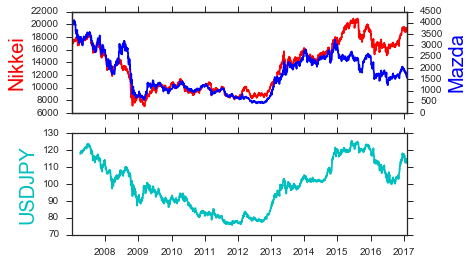

In [6]:
# plot data ----------------------------------------
fig, (ax, bx) = plt.subplots(2, sharex = True)
## Nikkei
ax.plot(date_Nikkei, data_Nikkei['始値'][:], c='r')
ax.set_ylabel('Nikkei', color='r', fontsize=20)
## Mazda
ax1 = ax.twinx()
ax1.plot(date_Mazda, data_Mazda['始値'][:], c='b')
ax1.set_ylabel('Mazda', color='b', fontsize=20)
## fx USDJPY
bx.plot(date_fx, data_fx['始値'][:], c='c')
bx.set_ylabel('USDJPY', color='c', fontsize=20)

# calculate Beta Coefficient
print(sc.calcBetaCoefficient(data_Mazda, data_Nikkei))

plt.show()
